<img src='http://hilpisch.com/taim_logo.png' width="350px" align="right">

# Artificial Intelligence in Finance

## Reinforcement Learning

&copy; Dr Yves J Hilpisch | The Python Quants GmbH

http://aimachine.io | http://twitter.com/dyjh

## Imports

In [1]:
import os
import math
import random
import numpy as np
import pandas as pd
from pylab import plt, mpl
plt.style.use('seaborn-v0_8')
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'
np.set_printoptions(precision=4, suppress=True)
os.environ['PYTHONHASHSEED'] = '0'

In [2]:
import warnings
warnings.simplefilter('ignore')

## `CartPole` Environment 

In [3]:
import gym

In [4]:
env = gym.make('CartPole-v0')

In [5]:
# env.seed(100)
env.action_space.seed(100)

[100]

In [6]:
env.observation_space

Box([-4.8000e+00 -3.4028e+38 -4.1888e-01 -3.4028e+38], [4.8000e+00 3.4028e+38 4.1888e-01 3.4028e+38], (4,), float32)

In [7]:
env.observation_space.low.astype(np.float16)

array([-4.8  ,   -inf, -0.419,   -inf], dtype=float16)

In [8]:
env.observation_space.high.astype(np.float16)

array([4.8  ,   inf, 0.419,   inf], dtype=float16)

In [9]:
state = env.reset()

In [10]:
state

(array([ 0.0229, -0.0006,  0.0428, -0.0344], dtype=float32), {})

In [11]:
env.action_space

Discrete(2)

In [12]:
env.action_space.n

2

In [13]:
env.action_space.sample()

1

In [14]:
env.action_space.sample() 

1

In [15]:
a = env.action_space.sample()
a

0

In [16]:
state, reward, trunc, done, info = env.step(a)
state, reward, trunc, done, info

/Users/yves/Python/envs/aiif/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


(array([ 0.0229, -0.1963,  0.0421,  0.2715], dtype=float32),
 1.0,
 False,
 False,
 {})

In [17]:
env.reset()
for e in range(1, 200):
    a = env.action_space.sample()
    state, reward, done, trunc, info = env.step(a) 
    print(f'step={e:2d} | state={state} | action={a} | reward={reward}')
    if done and (e + 1) < 200:
        print('*** FAILED ***')
        break

step= 1 | state=[-0.0072  0.2443 -0.0291 -0.3022] | action=1 | reward=1.0
step= 2 | state=[-0.0023  0.0496 -0.0351 -0.0189] | action=0 | reward=1.0
step= 3 | state=[-0.0013 -0.145  -0.0355  0.2625] | action=0 | reward=1.0
step= 4 | state=[-0.0042 -0.3396 -0.0302  0.5438] | action=0 | reward=1.0
step= 5 | state=[-0.011  -0.5343 -0.0194  0.8268] | action=0 | reward=1.0
step= 6 | state=[-0.0217 -0.3389 -0.0028  0.5281] | action=1 | reward=1.0
step= 7 | state=[-0.0284 -0.1437  0.0077  0.2346] | action=1 | reward=1.0
step= 8 | state=[-0.0313  0.0513  0.0124 -0.0557] | action=1 | reward=1.0
step= 9 | state=[-0.0303  0.2462  0.0113 -0.3444] | action=1 | reward=1.0
step=10 | state=[-0.0254  0.051   0.0044 -0.0482] | action=0 | reward=1.0
step=11 | state=[-0.0244  0.246   0.0035 -0.3395] | action=1 | reward=1.0
step=12 | state=[-0.0194  0.4411 -0.0033 -0.6311] | action=1 | reward=1.0
step=13 | state=[-0.0106  0.6363 -0.0159 -0.9248] | action=1 | reward=1.0
step=14 | state=[ 0.0021  0.4414 -0.03

In [18]:
done

True

## Dimensionality Reduction

See http://kvfrans.com/simple-algoritms-for-solving-cartpole/.

In [19]:
np.random.seed(100)

In [20]:
weights = np.random.random(4) * 2 - 1

In [21]:
weights

array([ 0.0868, -0.4433, -0.151 ,  0.6896])

In [22]:
state = env.reset()[0]

In [23]:
state

array([ 0.0308,  0.0217, -0.0381, -0.0052], dtype=float32)

In [24]:
s = np.dot(state, weights)
s

-0.004784471151783376

## Action Rule

In [25]:
if s < 0:
    a = 0
else:
    a = 1

In [26]:
a

0

## Total Reward per Episode

In [27]:
def run_episode(env, weights):  
    state = env.reset()[0]
    treward = 0
    for _ in range(200):
        s = np.dot(state, weights)
        a = 0 if s < 0 else 1
        state, reward, done, trunc, info = env.step(a)
        treward += reward
        if done:
            break
    return treward

In [28]:
run_episode(env, weights)

67.0

## Simple Learning 

In [29]:
def set_seeds(seed=100):
    random.seed(seed)
    np.random.seed(seed)
    # env.seed(seed)

In [30]:
set_seeds()
num_episodes = 1000

In [31]:
besttreward = 0
for e in range(1, num_episodes + 1):
    weights = np.random.rand(4) * 2 - 1
    treward = run_episode(env, weights)
    if treward > besttreward:
        besttreward = treward
        bestweights = weights
        if treward == 200:
            print(f'SUCCESS | episode={e}')
            break
        print(f'UPDATE  | episode={e}')

UPDATE  | episode=1
SUCCESS | episode=2


In [32]:
weights

array([-0.9906, -0.7569,  0.3415,  0.6517])

## Testing the Results

In [33]:
res = []
for _ in range(100):
    treward = run_episode(env, weights)
    res.append(treward)
res[:10]

[67.0, 98.0, 42.0, 180.0, 48.0, 121.0, 134.0, 84.0, 131.0, 48.0]

In [34]:
sum(res) / len(res)

91.54

## DNN Learning

In [35]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '5'

In [36]:
import tensorflow as tf
from tensorflow import keras

In [37]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [38]:
from keras.layers import Dense, Dropout
from keras.models import Sequential
from sklearn.metrics import accuracy_score

In [39]:
def set_seeds(seed=100):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    # env.seed(seed)
    env.action_space.seed(seed)

In [40]:
class NNAgent:
    def __init__(self):
        self.max = 0
        self.scores = list()
        self.memory = list()
        self.model = self._build_model()
        
    def _build_model(self):
        model = Sequential()
        model.add(Dense(24, input_dim=4,
                        activation='relu'))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy',
                      optimizer=keras.optimizers.legacy.RMSprop(learning_rate=0.001))
        return model
        
    def act(self, state):
        if random.random() <= 0.5:
            return env.action_space.sample()
        action = np.where(self.model.predict(
            state, batch_size=None)[0, 0] > 0.5, 1, 0)
        return action
                    
    def train_model(self, state, action):
        self.model.fit(state, np.array([action,]),
                       epochs=1, verbose=False)
    
    def learn(self, episodes):
        for e in range(1, episodes + 1):
            state = env.reset()[0]
            for _ in range(201):
                state = np.reshape(state, [1, 4])
                action = self.act(state)
                next_state, reward, done, trunc, info = env.step(action)
                if done:
                    score = _ + 1
                    self.scores.append(score)
                    self.max = max(score, self.max)
                    print('episode: {:4d}/{} | score: {:3d} | max: {:3d}'
                          .format(e, episodes, score, self.max), end='\r')
                    break
                self.memory.append((state, action))
                self.train_model(state, action)
                state = next_state

In [41]:
set_seeds(100)
agent = NNAgent()

In [42]:
episodes = 1000

In [43]:
agent.learn(episodes)

In [44]:
sum(agent.scores) / len(agent.scores)

35.459

In [45]:
f = np.array([m[0][0] for m in agent.memory])
f

array([[-0.0194, -0.0499, -0.017 , -0.0388],
       [-0.0204,  0.1455, -0.0178, -0.3368],
       [-0.0175, -0.0494, -0.0245, -0.0498],
       ...,
       [ 0.0689,  0.1926, -0.147 , -0.5935],
       [ 0.0728,  0.3894, -0.1589, -0.9286],
       [ 0.0806,  0.1968, -0.1774, -0.6898]], dtype=float32)

In [46]:
l = np.array([m[1] for m in agent.memory])
l

array([1, 0, 0, ..., 1, 0, 1])

In [47]:
accuracy_score(np.where(agent.model.predict(f) > 0.5, 1, 0), l)

0.5998142720334311

## Q Learning

See https://keon.io/deep-q-learning/

In [48]:
from collections import deque

In [49]:
class DQLAgent:
    def __init__(self, gamma=0.95, hu=24, opt=keras.optimizers.legacy.Adam,
           lr=0.001, finish=False):
        self.finish = finish
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.gamma = gamma
        self.batch_size = 32
        self.max_treward = 0
        self.averages = list()
        self.memory = deque(maxlen=2000)
        self.osn = env.observation_space.shape[0]
        self.model = self._build_model(hu, opt, lr)
        
    def _build_model(self, hu, opt, lr):
        model = Sequential()
        model.add(Dense(hu, input_dim=self.osn,
                        activation='relu'))
        model.add(Dense(hu, activation='relu'))
        model.add(Dense(env.action_space.n, activation='linear'))
        model.compile(loss='mse', optimizer=opt(learning_rate=lr))
        return model
        
    def act(self, state):
        if random.random() <= self.epsilon:
            return env.action_space.sample()
        action = self.model.predict(state)[0]
        return np.argmax(action)
    
    def replay(self):
        batch = random.sample(self.memory, self.batch_size)
        for state, action, reward, next_state, done in batch:
            if not done:
                reward += self.gamma * np.amax(
                    self.model.predict(next_state)[0])
            target = self.model.predict(state)
            target[0, action] = reward
            self.model.fit(state, target, epochs=1,
                           verbose=False)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
    
    def learn(self, episodes):
        trewards = []
        for e in range(1, episodes + 1):
            state = env.reset()[0]
            state = np.reshape(state, [1, self.osn])
            for _ in range(5000):
                action = self.act(state)
                next_state, reward, done, trunc, info = env.step(action)
                next_state = np.reshape(next_state,
                                        [1, self.osn])
                self.memory.append([state, action, reward,
                                     next_state, done])
                state = next_state
                if trunc:
                    treward = _ + 1
                    trewards.append(treward)
                    av = sum(trewards[-25:]) / 25
                    self.averages.append(av)
                    self.max_treward = max(self.max_treward, treward)
                    templ = 'episode: {:4d}/{} | treward: {:4d} | '
                    templ += 'av: {:6.1f} | max: {:4d}'
                    print(templ.format(e, episodes, treward, av,
                                       self.max_treward), end='\r')
                    break
            if av > 195 and self.finish:
                print()
                break
            if len(self.memory) > self.batch_size:
                self.replay()
    def test(self, episodes):
        trewards = []
        for e in range(1, episodes + 1):
            state = env.reset()[0]
            for _ in range(5001):
                state = np.reshape(state, [1, self.osn])
                action = np.argmax(self.model.predict(state)[0])
                next_state, reward, done, trunc, info = env.step(action)
                state = next_state
                if trunc:
                    treward = _ + 1
                    trewards.append(treward)
                    print('episode: {:4d}/{} | treward: {:4d}'
                          .format(e, episodes, treward), end='\r')
                    break
        return trewards

In [50]:
episodes = 1000

In [51]:
set_seeds(100)
agent = DQLAgent(finish=True)

In [52]:
%time agent.learn(episodes)

episode:   25/1000 | treward:  200 | av:  200.0 | max:  200
CPU times: user 986 ms, sys: 186 ms, total: 1.17 s
Wall time: 924 ms


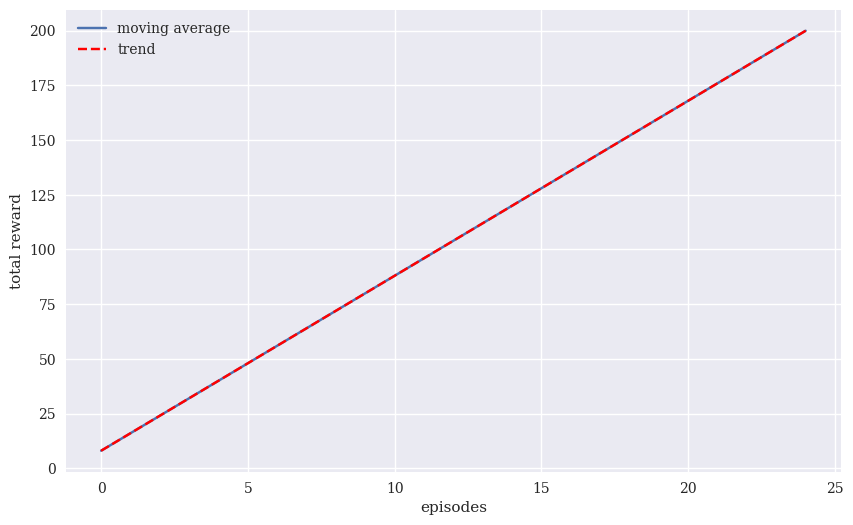

In [53]:
plt.figure(figsize=(10, 6))
x = range(len(agent.averages))
y = np.polyval(np.polyfit(x, agent.averages, deg=3), x)
plt.plot(agent.averages, label='moving average')
plt.plot(x, y, 'r--', label='trend')
plt.xlabel('episodes')
plt.ylabel('total reward')
plt.legend();

In [54]:
trewards = agent.test(100)

In [55]:
sum(trewards) / len(trewards)

200.0

## Finance Environment

In [56]:
class observation_space:
    def __init__(self, n):
        self.shape = (n,)

In [57]:
class action_space:
    def __init__(self, n):
        self.n = n
    def seed(self, seed):
        pass
    def sample(self):
        return random.randint(0, self.n - 1)

In [58]:
class Finance:
    url = 'http://hilpisch.com/aiif_eikon_eod_data.csv'
    def __init__(self, symbol, features):
        self.symbol = symbol
        self.features = features
        self.observation_space = observation_space(4)
        self.osn = self.observation_space.shape[0]
        self.action_space = action_space(2)
        self.min_accuracy = 0.475
        self._get_data()
        self._prepare_data()
    def _get_data(self):
        self.raw = pd.read_csv(self.url, index_col=0,
                               parse_dates=True).dropna()
    def _prepare_data(self):
        self.data = pd.DataFrame(self.raw[self.symbol])
        self.data['r'] = np.log(self.data / self.data.shift(1))
        self.data.dropna(inplace=True)
        self.data = (self.data - self.data.mean()) / self.data.std()
        self.data['d'] = np.where(self.data['r'] > 0, 1, 0)
    def _get_state(self):
        return self.data[self.features].iloc[
            self.bar - self.osn:self.bar].values
    def seed(self, seed=None):
        pass
    def reset(self):
        self.treward = 0
        self.accuracy = 0
        self.bar = self.osn
        state = self.data[self.features].iloc[
            self.bar - self.osn:self.bar]
        return state.values, {}
    def step(self, action):
        trunc = False
        correct = action == self.data['d'].iloc[self.bar]
        reward = 1 if correct else 0
        self.treward += reward
        self.bar += 1
        self.accuracy = self.treward / (self.bar - self.osn)
        if self.bar >= len(self.data):
            done = True; trunc = True
        elif reward == 1:
            done = False
        elif (self.accuracy < self.min_accuracy and
              self.bar > self.osn + 10):
            done = True; trunc = True
        else:
            done = False
        state = self._get_state()
        info = {}
        return state, reward, done, trunc, info

In [59]:
env = Finance('EUR=', 'EUR=')

In [60]:
env.reset()

(array([1.819 , 1.8579, 1.7749, 1.8579]), {})

In [61]:
a = env.action_space.sample()
a

0

In [62]:
env.step(a)

(array([1.8579, 1.7749, 1.8579, 1.947 ]), 0, False, False, {})

In [63]:
set_seeds(100)
agent = DQLAgent(gamma=0.5, opt=keras.optimizers.legacy.RMSprop)

In [64]:
episodes = 1000

In [65]:
%time agent.learn(episodes)

CPU times: user 5min 59s, sys: 59.8 s, total: 6min 59s 2511
Wall time: 5min 49s


In [66]:
agent.test(3)

[2511, 2511, 2511]

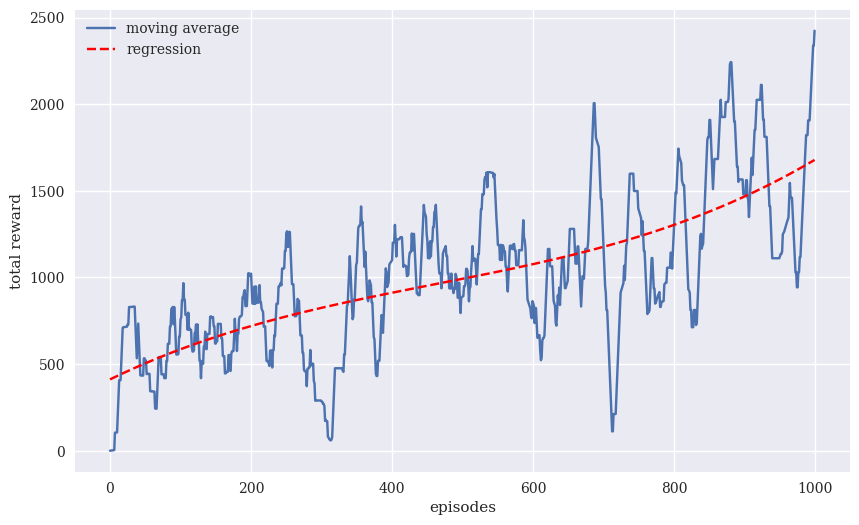

In [67]:
plt.figure(figsize=(10, 6))
x = range(len(agent.averages))
y = np.polyval(np.polyfit(x, agent.averages, deg=3), x)
plt.plot(agent.averages, label='moving average')
plt.plot(x, y, 'r--', label='regression')
plt.xlabel('episodes')
plt.ylabel('total reward')
plt.legend();

<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

<a href="http://tpq.io" target="_blank">http://tpq.io</a> | <a href="http://twitter.com/dyjh" target="_blank">@dyjh</a> | <a href="mailto:training@tpq.io">training@tpq.io</a>